# Identifying Stars and Galaxies from Sloan Digital Sky Survey Photometric Data

An interesting task in large-scale astronomical surveys is automated classification in near real-time. This classification can be performed directly on the imaging data or a range of photometric model properties of these objects. While the former approach provides more information, the latter promises faster results due to a significantly lower level of complexity.

*This toy project investigates whether it is possible to distinguish between [stars](https://en.wikipedia.org/wiki/Star), [spiral galaxies](https://en.wikipedia.org/wiki/Spiral_galaxy), and [elliptical galaxies](https://en.wikipedia.org/wiki/Elliptical_galaxy) based on only a few photometric properties.*

While stars appear as point sources, galaxies are extended objects; spiral galaxies are disks with spiral-like features and pronounced centers (nuclei), whereas elliptical galaxies appear usually blurry without clear structure and less pronounced nuclei.

We will setup a machine learning model that will use public data provided by the Sloan Digital Sky Survey (SDSS), which is a multi-band imaging and spectroscopic telescope survey that covers about 35% of the entire night sky. Imaging in the Sloan photometric system bands *u*, *g*, *r*, *i*, and *z*, the survey scans the accessible sky repeatedly, observing stars, galaxies, nebulae, and Solar System objects. See https://www.sdss.org/ for more information on the survey.

Training data for this project are taken from SDSS and the galaxy classification project [Galaxy Zoo](https://www.zooniverse.org/projects/zookeeper/galaxy-zoo/), in which citizen scientists visually inspect SDSS images in order to classify galaxies into different classes, including elliptical and spiral galaxies.

## Photometric Models

Photometry means the measurement of the brightness of a celestial source using a range of different photometric models:

### PSF Model

The [Point Spread Function](https://en.wikipedia.org/wiki/Point_spread_function) (PSF) refers to the response of an imaging system to a point source. Stars, which are too far away to be resolved spatially, are perfect examples for point sources. PSF photometry means the measurement of an object's brightness by fitting a model of the expected PSF to the object. Hence, PSF photometry is perfectly suited to measure the brightness of point sources, but not so much for extended sources, as extended emission is not considered in this model.

### Petrosian Model

Petrosian or Kron photometry uses a circular or elliptical aperture that is fit to the second order moments of the target's brightness distribution. The photometric model is described through a *radius* that encircles a given fraction of the target's total brightness and - if an elliptical aperture is used - a measure of the *elongation* of the ellipse (sometimes referred to as the *AB* ratio, which is the ratio of the semi-major and semi-minor axis of the ellipse). The Petrosian model is applicable to both stars and extended galaxies.


### de Vaucouleurs Model

The [de Vaucouleurs' law](https://en.wikipedia.org/wiki/De_Vaucouleurs%27_law) is intended to describe the brightness distribution of an elliptical galaxy. The effective radius of the model defines the radius of that isophote which contains half of the total brightness of the object. The model elongation is defined by the ratio of the semi-major and semi-minor axis. This model is purely empirical and tailored to elliptical galaxies.


### Exponential Model

Another approach to describe the brighntess distribution of galaxies is to assume a purely exponential brightness distribution. This model is described through an effective radius and the model elongation, defined as the ratio of the semi-major to the semi-minor axis. This model is also purely empirical and designed for galaxies.

This project investigates whether these properties - or maybe only a subset of them - are sufficient to distinguish between stars, spiral galaxies, and elliptical galaxies.

## Data

Photometric data for this project come from SDSS, which can be accessed trough [SkyServer](http://skyserver.sdss.org/dr15/en/tools/search/sql.aspx) and other services. SkyServer has been chosen over other services as both data sets required for this project could be retrieved from there (see below).

The data set required for this project consists of two parts: 
* the collection of galaxies that were classified in the framework of the Galaxy Zoo project, and 
* a sample of $10^5$ random objects from the SDSS catalog that were identified as stars.

### SDSS Photometric Data

For all sample objects, the following photometric properties have been queried: 
* `petroR50_r`: the radius containing 50% of the total Petrosian flux
* `petroR90_r`: the radius containing 90% of the total Petrosian flux
* `psfMag_r`: the PSF model magnitude 
* `deVRad_r`: the de Vaucouleurs model fit effective radius
* `deVAB_r`: the de Vaucouleurs model fit axis ratio
* `deVMag_r`: the de Vaucouleurs model magnitude
* `expRad_r`: the exponential model fit effective radius
* `expAB_r`: the exponential model fit axis ratio
* `expMag_r`: the exponential model magnitude

Note that for the sake of simplicity only Sloan r-band magnitudes are considered for this study and uncertainties are not considered.

### Training data

Training data has been obtained in two steps. 

1. photometric data for 200000 *stars* (condition `probPSF = 1`) have been obtained with the following SQL query from SkyServer and downloaded into  the file `stars.csv`:

       select 
         top 200000
         psfMag_r, 
         petroR50_r, petroR90_r, petroMag_r,
         deVRad_r, deVAB_r, deVMag_r,
         expRad_r, expAB_r, expMag_r
       from PhotoObjAll
       where probPSF = 1


2. photometric data for 200000 unanimously (condition `gx.uncertain = 0`) classified galaxies from the [Galaxy Zoo](https://www.zooniverse.org/projects/zookeeper/galaxy-zoo/) project; classification data are joined with photometric data while uncertatin classifications are rejected and downloaded into the file `galaxies.csv`:

       select 
         psfMag_r,
         petroR50_r, petroR90_r, petroMag_r, 
         deVRad_r, deVAB_r, deVMag_r, 
         expRad_r, expAB_r, expMag_r,
         gx.spiral, gx.elliptical
       from PhotoObjAll as phot
       join dbo.zooSpec as gx on phot.objID=gx.objid
       where gx.uncertain = 0

### Preparing the Data

After querying and downloading the data, both data sets are combined into a single `pandas` DataFrame containing a target identifier column, the value of which can either be `star`, `spiral`, or `elliptical`.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# galaxy data set
gxdata = pd.read_csv('galaxies.csv', na_values=('-1000', '-9999'), skiprows=1)
gxdata = gxdata.dropna()
gxdata['type'] = 'spiral'  # add type column
gxdata.loc[gxdata.elliptical == 1, 'type'] = 'elliptical'  # modify type where necessary
gxdata.drop(['elliptical', 'spiral'], axis=1, inplace=True)  # remove original one-hot type columns

# star data set
stdata = pd.read_csv('stars.csv', na_values=('-1000', '-9999'), skiprows=1)
stdata = stdata.dropna()
stdata['type'] = 'star'  # add type column

# combine both data sets
data = pd.concat([gxdata, stdata])

The following columns are available in the resulting DataFrame `data`:

In [2]:
data.columns

Index(['psfMag_r', 'petroR50_r', 'petroR90_r', 'petroMag_r', 'deVRad_r',
       'deVAB_r', 'deVMag_r', 'expRad_r', 'expAB_r', 'expMag_r', 'type'],
      dtype='object')

The distribution of the individual data points across the three object type classes is somewhat biased against elliptical galaxies and imbalanced:

In [3]:
data.groupby('type').psfMag_r.count()

type
elliptical     61985
spiral        189315
star          182853
Name: psfMag_r, dtype: int64

## Exploring the Data

We explore the data in order to indentify features that help to constrain the object type. 

### Axis Ratios

One immediate question is whether the two measured axis ratios `expAB_r` and `deVAB_r` are comparable. Despite using different model definitions, they should be very similar. We check this hypothesis using a two-sided KS test: 

In [4]:
from scipy.stats import ks_2samp

ks_2samp(data['deVAB_r'], data['expAB_r'])

Ks_2sampResult(statistic=0.036586180447906624, pvalue=6.124554812469728e-253)

The resulting statistic is very small, which means that we cannot rule out that both samples are drawn from the same population. Hence, we only need one of the two parameters in the training data sample and can ignore the other one.

### Diagnostic Properties

The following plots show histograms of two or more individual photometric properties plotted in the same plot and grouped by  target type. The idea is to identify those properties that show the most spread between the different target types.

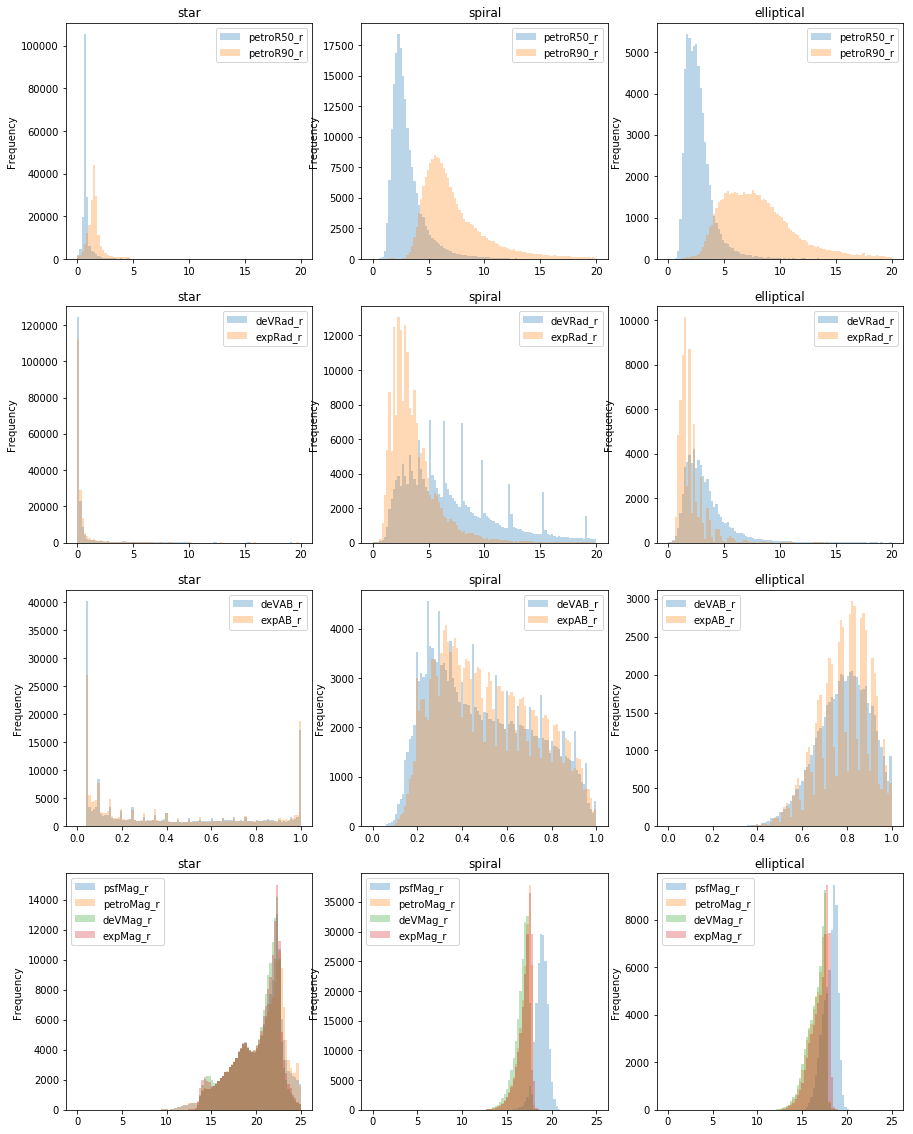

In [5]:
# create a 9x9 panel
f, ax = plt.subplots(4, 3, figsize=(15,20))
ax = np.array(ax).ravel()

# loop through parameter space
for i, params in enumerate([['petroR50_r', 'petroR90_r', 20], ['deVRad_r', 'expRad_r', 20], 
                             ['deVAB_r', 'expAB_r', 1], ['psfMag_r', 'petroMag_r', 'deVMag_r', 'expMag_r', 25]]):
    *columns, range_limit = params
    # loop through the different object types
    for j, subset in enumerate(['star', 'spiral', 'elliptical']):
        data[columns].loc[data['type'] == subset].plot.hist(
            alpha=0.3, bins=np.linspace(0, range_limit, 100), ax=ax[3*i+j], title=subset)

The columns (from left-most to right-most) show the distribution of the respective properties for stars, spiral galaxies, and elliptical galaxies, respectively.

The different effective radius distributions (`petroR50_r`, `petroR90_r`, `deVRad_r`, `expRad_r`) show clear differences between stars and galaxies. Especially `deVRad_r` and `expRad_r` also seem diagnostic for the differences between elliptical and spiral galaxies. All four properties seem to be useful in a machine learning approach. Differences in the distributions between the two galaxy types stem from the different distributions of light as a function of the radial distance from the galaxy's nucleus.

As already shown by the KS-test performed earlier, the distributions of `deVAB_r` and `expAB_r` are basically identical and no information gets lost if one of the two features is ignored.

Finally, the difference between `psfMag_r` and any one of the other magnitudes seems to hold information that might improve the distinction between stars and galaxies, as well as the different galaxy types. In the case of stars, the magnitude distributions are basically identical, whereas in the case of the two galaxy types, PSF magnitudes seem to be significantly different from the other flavors, which mostly overlap each other. However, there seems to be a difference in the distribution modes, which might be a useful diagnostic tool. This difference in the distribution modes might originate from a lack of a pronounced nucleus in most elliptical galaxies in contrast to spiral galaxies.

### Feature Engineering

Some of the aforementioned photometric properties show promise as diagnostic tools to distinguish the individual object types. The following plots show an attempt to engineer additional features that are linear combinations of the original features to exploit the differences between them. For the sake of simplicity, we only consider differences and ratios (quotients) of two parameters.

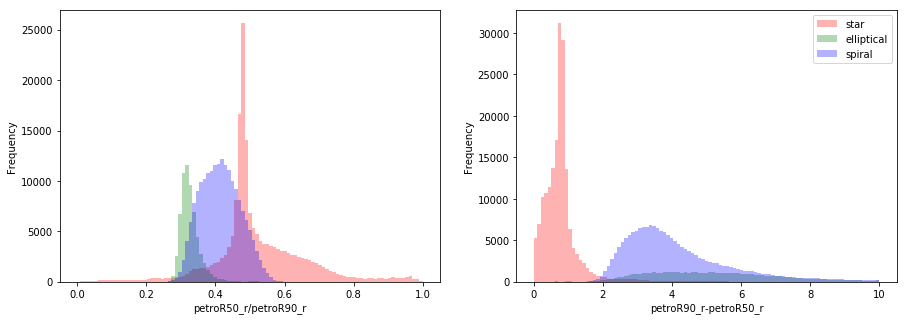

In [6]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

newfeature = data['petroR50_r']/data['petroR90_r']
bins = np.linspace(0, 1, 100)
newfeature.loc[data['type'] == 'star'].plot.hist(bins=bins, alpha=0.3, ax=ax1, color='red', label='star')
newfeature.loc[data['type'] == 'elliptical'].plot.hist(bins=bins, alpha=0.3, ax=ax1, color='green', label='elliptical')
newfeature.loc[data['type'] == 'spiral'].plot.hist(bins=bins, alpha=0.3, ax=ax1, color='blue', label='spiral')
ax1.set_xlabel('petroR50_r/petroR90_r')

newfeature = data['petroR90_r']-data['petroR50_r']
bins = np.linspace(0, 10, 100)
newfeature.loc[data['type'] == 'star'].plot.hist(bins=bins, alpha=0.3, ax=ax2, color='red', label='star')
newfeature.loc[data['type'] == 'elliptical'].plot.hist(bins=bins, alpha=0.3, ax=ax2, color='green', label='elliptical')
newfeature.loc[data['type'] == 'spiral'].plot.hist(bins=bins, alpha=0.3, ax=ax2, color='blue', label='spiral')
ax2.set_xlabel('petroR90_r-petroR50_r')
plt.legend()


While the difference `petroR90_r-petroR50_r` is able to distinguish between stars and galaxies, the quotient `petroR50_r/petroR90_r` provides some leverage on the distinction between elliptical and spiral galaxies.

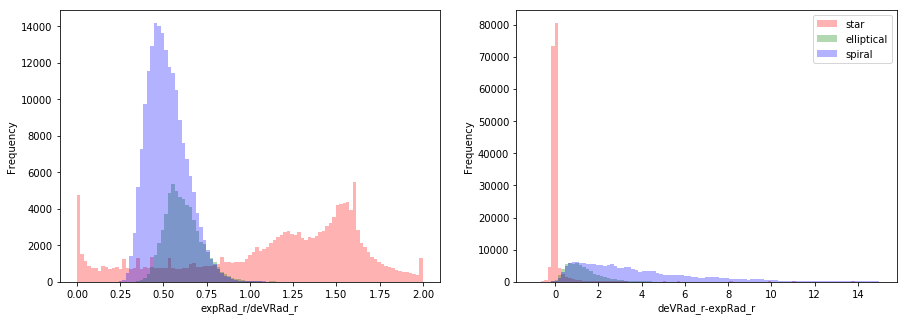

In [7]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

newfeature = data['expRad_r']/data['deVRad_r'].replace(0, 0.0001) # replace values to prevent division by zero
bins = np.linspace(0, 2, 100)
newfeature.loc[data['type'] == 'star'].plot.hist(bins=bins, alpha=0.3, ax=ax1, color='red', label='star')
newfeature.loc[data['type'] == 'elliptical'].plot.hist(bins=bins, alpha=0.3, ax=ax1, color='green', label='elliptical')
newfeature.loc[data['type'] == 'spiral'].plot.hist(bins=bins, alpha=0.3, ax=ax1, color='blue', label='spiral')
ax1.set_xlabel('expRad_r/deVRad_r')

newfeature = data['deVRad_r']-data['expRad_r']
bins = np.linspace(-1, 15, 100)
newfeature.loc[data['type'] == 'star'].plot.hist(bins=bins, alpha=0.3, ax=ax2, color='red', label='star')
newfeature.loc[data['type'] == 'elliptical'].plot.hist(bins=bins, alpha=0.3, ax=ax2, color='green', label='elliptical')
newfeature.loc[data['type'] == 'spiral'].plot.hist(bins=bins, alpha=0.3, ax=ax2, color='blue', label='spiral')
ax2.set_xlabel('deVRad_r-expRad_r')
plt.legend()

While `expRad_r/deVRad_r` leads to a complete overlap of the two galaxy types and stars, `deVRad_r-expRad_r` clearly separates stars from the galaxies and provides some handle on the two galaxy types. The latter seems to be more promising as a diagnostic feature, although only to a limited extent.

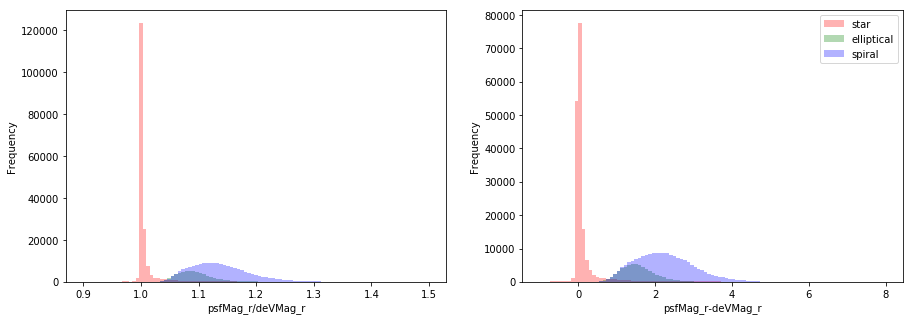

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

newfeature = data['psfMag_r']/data['deVMag_r'].replace(0, 0.0001) # replace values to prevent division by zero
bins = np.linspace(0.9, 1.5, 100)
newfeature.loc[data['type'] == 'star'].plot.hist(bins=bins, alpha=0.3, ax=ax1, color='red', label='star')
newfeature.loc[data['type'] == 'elliptical'].plot.hist(bins=bins, alpha=0.3, ax=ax1, color='green', label='elliptical')
newfeature.loc[data['type'] == 'spiral'].plot.hist(bins=bins, alpha=0.3, ax=ax1, color='blue', label='spiral')
ax1.set_xlabel('psfMag_r/deVMag_r')

newfeature = data['psfMag_r']-data['deVMag_r']
bins = np.linspace(-1, 8, 100)
newfeature.loc[data['type'] == 'star'].plot.hist(bins=bins, alpha=0.3, ax=ax2, color='red', label='star')
newfeature.loc[data['type'] == 'elliptical'].plot.hist(bins=bins, alpha=0.3, ax=ax2, color='green', label='elliptical')
newfeature.loc[data['type'] == 'spiral'].plot.hist(bins=bins, alpha=0.3, ax=ax2, color='blue', label='spiral')
ax2.set_xlabel('psfMag_r-deVMag_r')
plt.legend()

Both the magnitude difference and quotient look remarkably similar, which is a result of the logarithmic nature of the magnitudes. In this case, `devMag_r` were chosen, but the resulting distributions using `expMag_r` look very similar.

### Feature Selection

The final list of features used in this study are:
* `MagDiff` == `psfMag_r-deVMag_r`
* `PetroQuot` == `petroR50_r/petroR90_r`
* `RadDiff` == `deVRad_r-expRad_r`
* `deVAB_r` (but we could use `expAB_r` just as well)
* `psfMag_r` (in order to account for absolute magnitude effects)

## Classification

### Data Preparation

Based on the findings above, we train our model on the aforementioned features only. The target labels used in the classification are provided from the `type` column.

In [9]:
data['MagDiff'] = data.psfMag_r - data.deVMag_r
data['PetroQuot'] = data.petroR50_r / data.petroR90_r
data['RadDiff'] = data.deVRad_r - data.expRad_r

featurelist = ['MagDiff', 'PetroQuot', 'RadDiff', 'deVAB_r', 'psfMag_r']
targetlist = ['type']

### Model Selection

The following code trains a model to the data and checks its performance based on the *f1 score*, which has been chosen instead of the simple accuracy to compensate for the imbalanced distribution of the different object types across the data set.

The code performs a grid search over a discrete parameter space to find those model parameters leading to the highest f1 scores. As part of the grid search, 90% of the data in `data` are repeatedly and randomly split into a training, validation, and test set to independently check the performance of the models. The remaining 10% of `data` will be used as independent validation data for a confusion matrix (see below).

Different classification models have been tested (including Random Forests, Gradient Boosting, Linear Support Vector Machines, Multi-Layer Perceptrons), but all models performed at the same level of accuracy as a simple Decision Tree classifier. For the sake of simplicity and due to the significantly reduced runtime compared to the other models, a Decision Tree is used for this project. 

In [10]:
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

# split sample; test samples will be used in confusion matrix later on
X_train, X_test, y_train, y_test = train_test_split(data[featurelist], data[targetlist], 
                                                    test_size=0.1, random_state=42)

# perform grid search with Decision Tree classifier
param_grid = {'max_depth': [5, 10, 20], 'min_samples_leaf': [1, 10, 20, 30]}
grid = GridSearchCV(DecisionTreeClassifier(), param_grid=param_grid, cv=5, n_jobs=-1, scoring='f1_weighted') 
grid.fit(X_train, y_train)
print('training completed')

training completed


In [11]:
print('parameters providing the best performance:', grid.best_params_)
print('best f1 score:', grid.best_score_)

parameters providing the best performance: {'max_depth': 10, 'min_samples_leaf': 20}
best f1 score: 0.9639776806066553


The best f1 score that can be achieved with this model is 96.4%, which is a pretty good result given the fact that only 5 features are used in the classification.

We investigate the accuracy of the model in more detail using a confusion matrix, which provides an overview over correct and false classifications. In order to provide an unbiased estimate for the confusion, we use the previously derived test samples (`X_test`, `y_test`), which has not been used in the grid search.

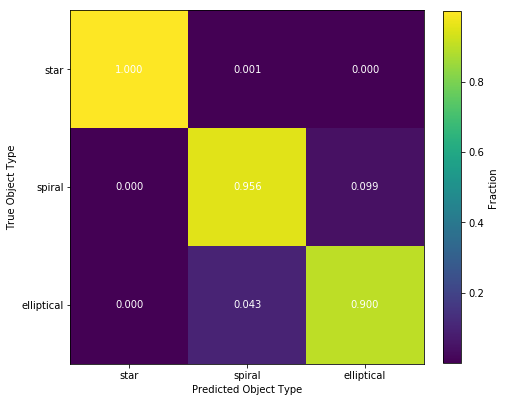

In [12]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

labels = ['star', 'spiral', 'elliptical']

# predict test sample
y_pred = grid.predict(X_test)

# create confusion matrix for test sample
cm = confusion_matrix(y_test, y_pred, labels=labels)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# plot confusion matrix
f = plt.figure(figsize=(7,7))
cm_map = plt.imshow(cm, cmap=plt.cm.viridis)
plt.xticks(range(3), labels)
plt.yticks(range(3), labels)
plt.xlabel('Predicted Object Type')
plt.ylabel('True Object Type')
colorbar = plt.colorbar(cm_map, label='Fraction', fraction=0.045, pad=0.05)

# add cell labels
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.annotate('{:4.3f}'.format(cm[i][j]), xy=(i,j), color='white',
                     horizontalalignment='center', verticalalignment='center')

The values on the diagonal - the true positives - are clearly in the majority: stars are identified with a confidence of 100%, spiral galaxies with a confidence of 95.6%, and elliptical galaxies with a confidence of 90%. The highest level of confusion exists between the two galaxy types: 10% of spiral galaxies are mistaken for elliptical galaxies and 4.3% of elliptical galaxies are mistaken for spiral galaxies. 

The following list shows the relative weights of the features used in the model:

In [13]:
featureimp = grid.best_estimator_.feature_importances_
for feature in zip(featurelist, featureimp):
    print(feature)

('MagDiff', 0.622608857966802)
('PetroQuot', 0.16733372388632772)
('RadDiff', 0.007591654936831048)
('deVAB_r', 0.1006922367515579)
('psfMag_r', 0.10177352645848123)


`MagDiff` has the highest weight, which is most likely a result of its importance in distinguishing stars and galaxies in general. `RadDiff` clearly has the lowest weight of all features, rendering it nearly meaningless for this model which we already expected from the feature engineering analysis above.

## Validation on Abell 1631

We validate the model performance visually by checking the model performance on SDSS data obtained for galaxy cluster Abell 1631.

In order to obtain imaging and catalog data from SDSS, we use the `astroquery.sdss` submodule. `SDSS.query_region` checks the location of the corresponding data in the SDSS catalogs.

In [14]:
import astropy.units as u
from astropy import coordinates as coords
from astroquery.sdss import SDSS

# define cluster coordinates
pos = coords.SkyCoord('11h55m18.9s +23d24m31s', frame='icrs')

# obtain SDSS cross-id table
xid = SDSS.query_region(pos, radius=0.1*u.arcmin)
xid

<Table length=1>
       ra              dec               objid         run  rerun camcol field
    float64          float64             int64        int64 int64 int64  int64
---------------- ---------------- ------------------- ----- ----- ------ -----
178.829819910869 23.4098865905609 1237667783906033837  5194   301      6   426

We use the data set found, which is defined by `run=5194`, `field=426`, and `camcol=6`. We obtain the imaging data, wcs information from the image header, as well as the photometric catalog data for this field.

In [15]:
from astroquery.sdss import SDSS
from astropy.wcs import WCS 

sdss_img = SDSS.get_images(run=5194, field=426, camcol=6)

# extract image data and wcs information from image header
imgdat = sdss_img[0][0].data
wcs = WCS(sdss_img[0][0].header)

# define fields for catalog query
queryfields=('ra', 'dec', 'clean', 'psfMag_r', 'petroR50_r', 'petroR90_r', 'deVRad_r', 'deVMag_r', 'deVAB_r', 'expRad_r')

# query photometric catalog
phot = SDSS.query_photoobj(run=5194, field=426, camcol=6, fields=queryfields)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


We reject un-clean photometric measurements (e.g., spurious or saturated detections), as well as faint sources for the catalog to simplify the visual identification of the sources.

In [16]:
phot = phot.to_pandas()
phot = phot[phot.clean == 1] # remove unclean detections
phot = phot[phot.psfMag_r < 20] # remove faint sources

We plot the entire image and mark the locations of the sources to be classified using the trained model.

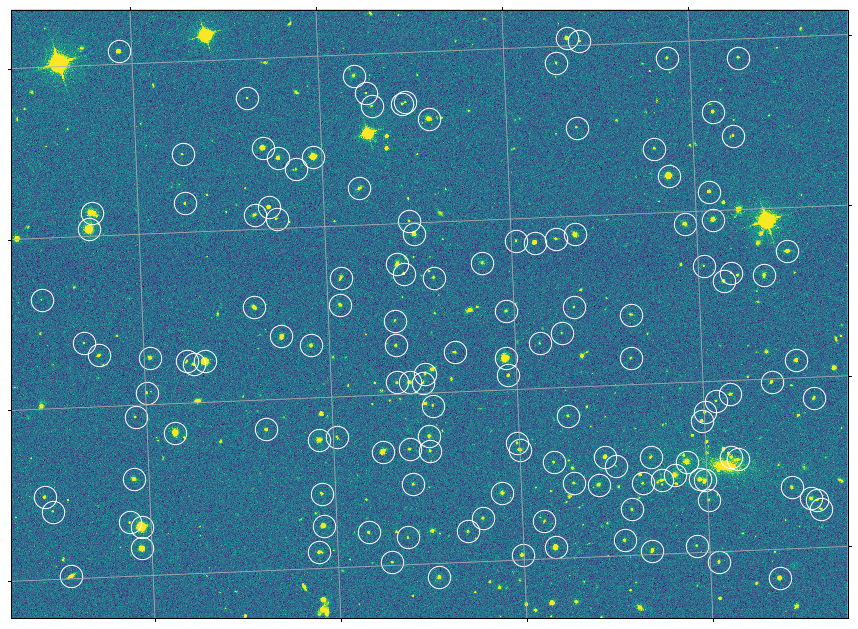

In [17]:
import matplotlib.pyplot as plt
from astropy.visualization import MinMaxInterval, ZScaleInterval, LinearStretch, LogStretch, ImageNormalize

# normalize and stretch image data
norm = ImageNormalize(imgdat, interval=ZScaleInterval(), stretch=LinearStretch())

# translate world coordinates to image coordinates
x, y = wcs.all_world2pix(phot['ra'], phot['dec'], 1)
phot['x'] = x
phot['y'] = y

# plot image data and mark sources from catalog
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection=wcs)
ax.imshow(imgdat, origin='lower', cmap=plt.cm.viridis, norm=norm)
phot.plot.scatter('x', 'y', color='none', edgecolor='white', s=500, marker='o', ax=ax)

In [18]:
print('total number of reliable sources in field:', len(phot))

total number of reliable sources in field: 142


We produce the same features for the validation data set as we did for the training data set and predict the class associations for the filtered sources. Note that the appearance and especially the background colors in the individual images vary as each image is scaled independently using a min-max scaling and a linear stretch.

In [19]:
# add engineered features to validation data
phot['MagDiff'] = phot.psfMag_r - phot.deVMag_r
phot['PetroQuot'] = phot.petroR50_r / phot.petroR90_r
phot['RadDiff'] = phot.deVRad_r - phot.expRad_r

# predict validation source classes
phot['target'] = grid.predict(phot[featurelist])

# sort by brightness for better visual impression
phot.sort_values('psfMag_r', inplace=True)

# count validation source class members
phot.groupby('target').ra.count()

target
elliptical    28
spiral        46
star          68
Name: ra, dtype: int64

The following plots show a selection of the brightests sources identified as stars (top), elliptical galaxies (center), and spiral galaxies (bottom). 

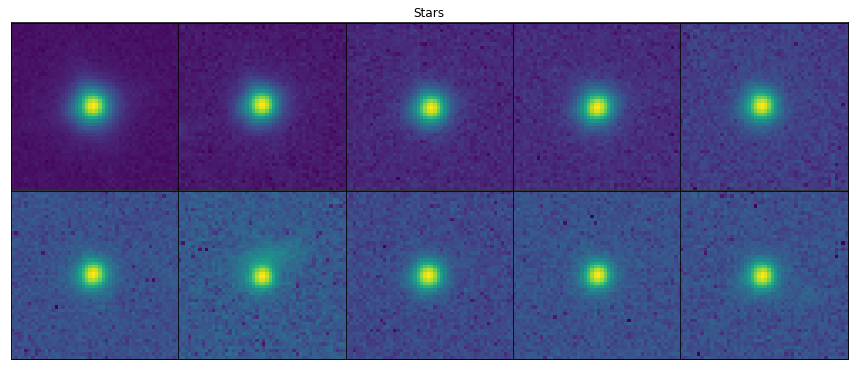

In [20]:
import matplotlib.gridspec as gridspec

def extract_thumbnail(x, y, size=50):
    return imgdat[int(x)-int(size/2):int(x)+int(size/2),
                 int(y)-int(size/2):int(y)+int(size/2)]

n=10

f = plt.figure(figsize = (15,3.1*int(n/5)))
plotgrid = gridspec.GridSpec(int(n/5), 5, wspace=0, hspace=0)

plt.title('Stars')
plt.xticks([])
plt.yticks([])

for i in range(n):
    thumbnail = extract_thumbnail(phot[phot['target']=='star'].y.iloc[i], 
                                  phot[phot['target']=='star'].x.iloc[i])
    norm = ImageNormalize(thumbnail, interval=MinMaxInterval(), stretch=LogStretch())

    ax = plt.Subplot(f, plotgrid[i])
    ax.imshow(thumbnail, origin='lower', cmap=plt.cm.viridis, norm=norm)
    ax.set_xticks([])
    ax.set_yticks([])
    f.add_subplot(ax)
    

Stars have been clearly identified - all examples shown here look almost identical. In contrast to the galaxies shown below, stars show a steep brightness gradient (indcated by the dark blue background in these plots). 

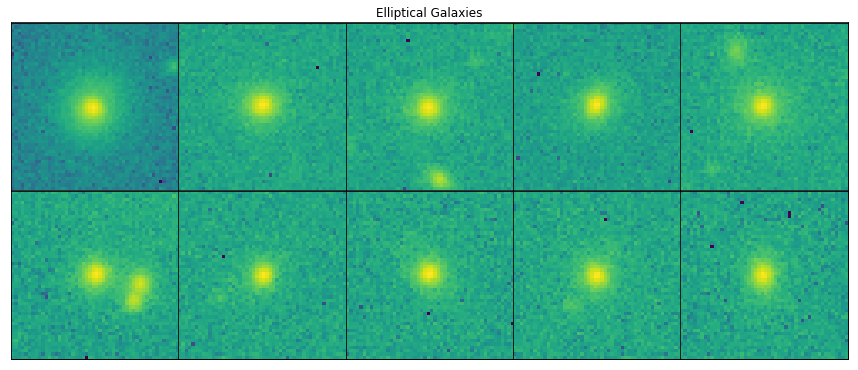

In [21]:
n=10

f = plt.figure(figsize = (15,3.1*int(n/5)))
plotgrid = gridspec.GridSpec(int(n/5), 5, wspace=0, hspace=0)

plt.title('Elliptical Galaxies')
plt.xticks([])
plt.yticks([])

for i in range(n):
    thumbnail = extract_thumbnail(phot[phot['target']=='elliptical'].y.iloc[i], 
                                  phot[phot['target']=='elliptical'].x.iloc[i])
    norm = ImageNormalize(thumbnail, interval=MinMaxInterval(), stretch=LogStretch())

    ax = plt.Subplot(f, plotgrid[i])
    ax.imshow(thumbnail, origin='lower', cmap=plt.cm.viridis, norm=norm)
    ax.set_xticks([])
    ax.set_yticks([])
    f.add_subplot(ax)

All elliptical galaxies show significantly more fuzziness as the stars shown above. Also, the much smaller stretch of colors indicates a much less pronounced nuclear brightness, which is generally indicative of elliptical galaxies.

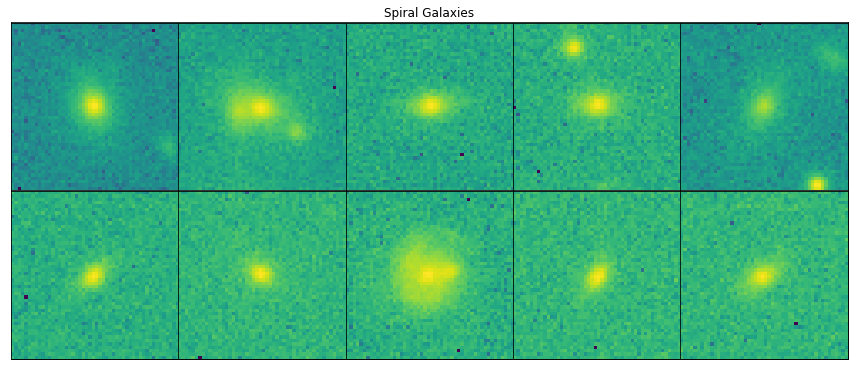

In [22]:
n=10

f = plt.figure(figsize = (15,3.1*int(n/5)))
plotgrid = gridspec.GridSpec(int(n/5), 5, wspace=0, hspace=0)

plt.title('Spiral Galaxies')
plt.xticks([])
plt.yticks([])

for i in range(n):
    thumbnail = extract_thumbnail(phot[phot['target']=='spiral'].y.iloc[i], 
                                  phot[phot['target']=='spiral'].x.iloc[i])
    norm = ImageNormalize(thumbnail, interval=MinMaxInterval(), stretch=LogStretch())

    ax = plt.Subplot(f, plotgrid[i])
    ax.imshow(thumbnail, origin='lower', cmap=plt.cm.viridis, norm=norm)
    ax.set_xticks([])
    ax.set_yticks([])
    f.add_subplot(ax)

As suggested by the confusion matrix (see above), there are some galaxies that could be counted into the opposite galaxy group, as well. Sone examples appear among the spiral galaxies shown here. However, most of the galaxies shown here exhibit more structure as those identified as elliptical galaxies above.

This final plot shows the classification of all filtered sources in the field.

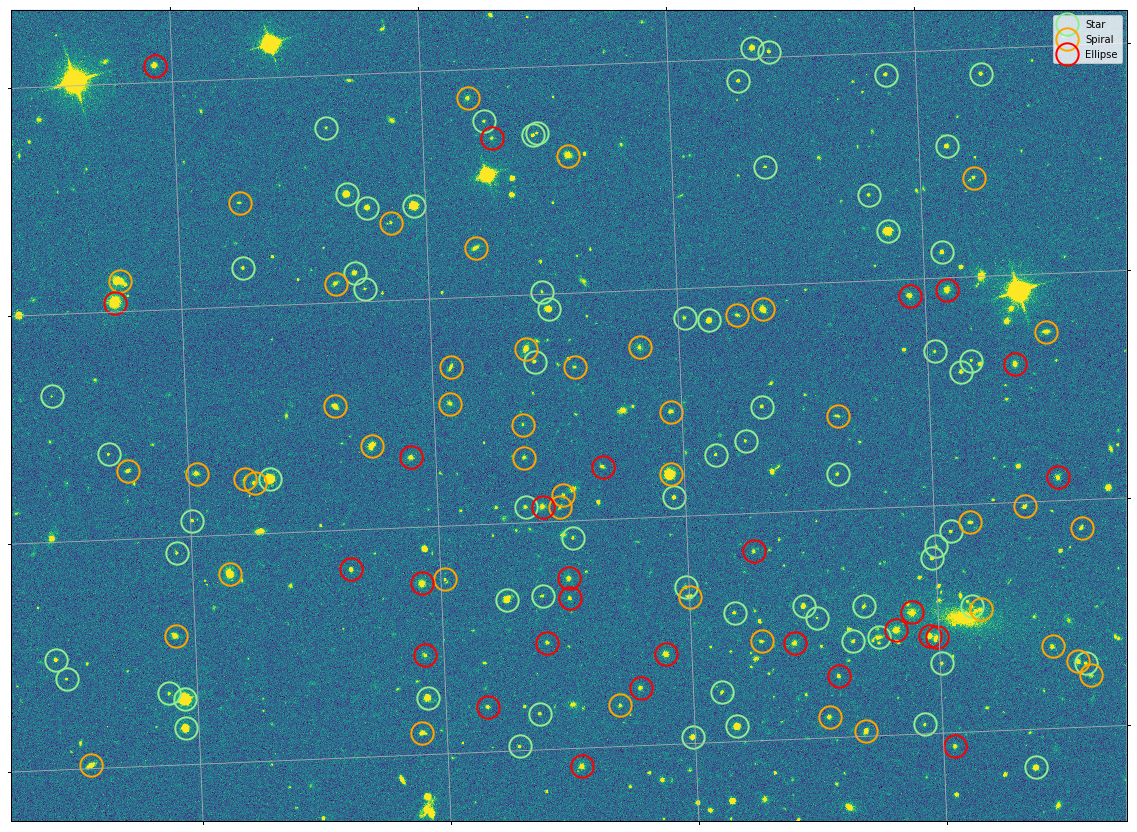

In [23]:
# normalize and stretch image data
norm = ImageNormalize(imgdat, interval=ZScaleInterval(), stretch=LinearStretch())

fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111, projection=wcs)
ax.imshow(imgdat, origin='lower', cmap=plt.cm.viridis, norm=norm)
phot[phot['target']=='star'].plot.scatter('x', 'y', edgecolor='lightgreen', ax=ax, marker='o', s=500, 
                                          color='none', lw=2, label='Star')
phot[phot['target']=='spiral'].plot.scatter('x', 'y', edgecolor='orange', ax=ax, marker='o', s=500, 
                                          color='none', lw=2, label='Spiral')
phot[phot['target']=='elliptical'].plot.scatter('x', 'y', edgecolor='red', ax=ax, marker='o', s=500, 
                                          color='none', lw=2, label='Ellipse')

## Discussion

This toy project shows that a machine learning model trained on only a handful of carefully selected and engineered features is able to reliably distinguish between stars and galaxies and with a high confidence can distinguish between spiral galaxies and elliptical galaxies. 

### Performance

The best-fit f1-score is 96.4% and based on the confusion matrix derived above:

* stars have a true positive rate of 100%; the rate of false positives is of the order of 0.1% (all of which are actually spiral galaxies).
* spiral galaxies have a true positive rate of 95.6%; the rate of false positives is 10%, all of which are actually elliptical galaxies.
* elliptical galaxies have a true positive rate of 90%; the rate of false positives is 4.3%, all of which are actually spiral galaxies.


### Feature Selection

SDSS provides a range of additional photometric and other properties that would improve the results of this study, including fit likelihoods for the individual photometric models. These high-level products were deliberately ignored in order to provide a general assessment of the applicability of this method to other surveys.

### Color Information

This entire study is based only on r-band data. Additional information that could be used in the classification could be extracted from the other bands that are available in the SDSS databases.

### Uncertainties

Feature uncertainties are not considered by the model. This is in part due to the fact that all magnitude uncertainties scale similarly and (probably) not much information can be extracted from those. Uncertainties have also been ignored in order to keep this toy project simple. Instead of accounting for uncertainties, the training and validation data sets have been cropped to remove unreliable or faint detections to improve the quality of the data.

### Model Complexity

Using a Decision Tree classifier, the model is easy to implement and performs well even for large amounts of data. A more complex model might perform better, but this level accuracy is sufficient for this kind of toy project. 

### Classification Reliability

The identification and classification of galaxies into the categories `spiral` and `elliptical` has been performed by humans and is hence affected by subjectivity. This effect on the classification reliability is minimized by only using unambiguously classified galaxies in the training sample. However, the reliability of the classification might still be affected for borderline cases like lenticular galaxies, which can be considered both elliptical and spiral galaxies. 

## Acknowledgements

This project makes use of data provided by the [Sloan Digital Sky Survey](https://www.sdss.org/) and the [Galaxy Zoo](https://www.zooniverse.org/projects/zookeeper/galaxy-zoo/) Project.
